# Introduction

This study is based on the publication [ATL-PHYS-PUB-2017-003](https://cds.cern.ch/record/2255226/files/ATL-PHYS-PUB-2017-003.pdf).

The corresponding code can be found on Micky Paganini's github page: https://github.com/mickypaganini/RNNIP.

In [18]:
import numpy as np
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers import GRU, LSTM, Dense, Dropout, Activation, Masking, Embedding, merge, Input, Flatten
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import unitnorm

# Input data

The input data we train on comes from two classes: The jet category is a classification "depending on the number of observed, expected, or missing hits
in the different layers of the silicon pixel and strip detectors" and it "attempts to
organize tracks based on impact parameter resolution." This is clearly a **categorical** paramater, i.e. the class numbers don't carry any hierarchical information. All other parameters ($S_{d_{0}}$, $S_{z_{0}}$, $p_{\text{T}}^{\text{frac}}$, $\Delta R(\text{track}, \text{jet})$) are **continuous** variables.

We will treat those classes differently. There are a number of ways to deal with categorical data, like for example one-hot encoding (OHE) or embedding. The pub note was inspired by natural language processing (NLP). I guess that's why they use an embedding layer to transform their categorical input.

I don't know much about embedding, but from googling a bit it seems to me like embedding is useful when there are many (i.e. hundreds or more) categories and when there is some kind of semantic connection between them (like certain words in phrases often go together). Both is not the case for our categories. As described in [ATL-PHYS-PUB-2015-022](https://cds.cern.ch/record/2037697/files/ATL-PHYS-PUB-2015-022.pdf) there exist 14 categories that are labeled from 0 to 13 (13 being the best category). I think it's perfectly fine to go with OHE for a first test. However, we might want to change this later. In the pub note a 2D unit vector was produced. With OHE we add 14 dimensions.

The continuous data will be normalized. That is, we will transform it in a way that is has zero mean and unit variance.

As right now no data is available, I will generate some random stuff. Just to see if the code crashes or not. The variables for this development stage are prepended `dev_`.

In [51]:
dev_length = int(1e5)
dev_categories = np.random.randint(0, 14, dev_length)
dev_sd0 = 0.1 * np.random.randint(-200, -10, dev_length)
dev_sz0 = 0.001 * np.random.randint(500, 1500, dev_length)
dev_ptfrac = 0.123 * np.random.randint(10, 200, dev_length)
dev_dr = 0.004455 * np.random.randint(1000, 1000000, dev_length)

data = pd.DataFrame()
# do not add categorical data for now
data['sd0'] = dev_sd0
data['sz0'] = dev_sz0
data['ptfrac'] = dev_ptfrac
data['dr'] = dev_dr

data.head()

sd0    sz0  ptfrac           dr
0  -7.9  0.683  14.637  4247.789040
1 -12.4  1.360  15.129  4432.506705
2 -15.8  0.935  17.220   140.252310
3 -10.1  0.502  17.220  3950.382150
4 -18.4  1.405   2.460   822.303900

### Mean normalize continuous variables

In [59]:
data = (data - data.mean()) / data.var()
data.head(3)

sd0       sz0    ptfrac        dr
0  0.088475 -3.788995  0.039322  0.001229
1 -0.061445  4.315660  0.050158  0.001341
2 -0.174718 -0.772196  0.096212 -0.001269

(array([  9951.,   9975.,  10022.,  10141.,   9899.,   9994.,  10174.,
         10002.,   9804.,  10038.]),
 array([ -3.14643455e-01,  -2.51676964e-01,  -1.88710473e-01,
         -1.25743983e-01,  -6.27774915e-02,   1.88999420e-04,
          6.31554904e-02,   1.26121981e-01,   1.89088472e-01,
          2.52054963e-01,   3.15021454e-01]),
 <a list of 10 Patch objects>)

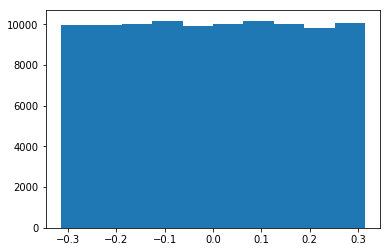

In [60]:
plt.hist(data['sd0'])

### Add categorical data and perform OHE

In [61]:
data['category'] = dev_categories

In [62]:
data_ohe = pd.concat([data, pd.get_dummies(data['category'])], axis=1, sort=False)

In [63]:
data_ohe = data_ohe.drop('category', axis=1)

In [64]:
data_ohe.head()

sd0       sz0    ptfrac        dr  0  1  2  3  4  5  6  7  8  9  10  \
0  0.088475 -3.788995  0.039322  0.001229  0  0  1  0  0  0  0  0  0  0   0   
1 -0.061445  4.315660  0.050158  0.001341  0  0  0  0  0  0  0  1  0  0   0   
2 -0.174718 -0.772196  0.096212 -0.001269  0  0  0  0  1  0  0  0  0  0   0   
3  0.015181 -5.955824  0.096212  0.001048  0  0  1  0  0  0  0  0  0  0   0   
4 -0.261338  4.854374 -0.228873 -0.000854  0  0  0  0  0  0  0  1  0  0   0   

   11  12  13  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0

### Only for dev set: Split into series of jets

Each event has a certain number of jets. To determine the number of jets in our dev set we simply draw a random number from a Poisson distribution.

For the real training data, this is of course not necessary

In [106]:
samples = 10000  # split into 2000 examples
nvars = len(data_ohe.columns)
timesteps = 15  # we do not really have timesteps - we have up to 15 tracks
data_tensor = np.zeros((samples, timesteps, nvars))

In [107]:
idx = 0
for i in range(samples):
    # use ntracks for this example
    ntracks = min(15, max(1, np.random.poisson(5)))
    for j in range(ntracks):
        for k, var in enumerate(data_ohe.columns):
            data_tensor[i,j,k] = data_ohe[var][idx]
        idx += 1
print('read {} entries from data_ohe'.format(idx))
    

read 49777 entries from data_ohe


In [102]:
data_ohe.head()

sd0       sz0    ptfrac        dr  0  1  2  3  4  5  6  7  8  9  10  \
0  0.088475 -3.788995  0.039322  0.001229  0  0  1  0  0  0  0  0  0  0   0   
1 -0.061445  4.315660  0.050158  0.001341  0  0  0  0  0  0  0  1  0  0   0   
2 -0.174718 -0.772196  0.096212 -0.001269  0  0  0  0  1  0  0  0  0  0   0   
3  0.015181 -5.955824  0.096212  0.001048  0  0  1  0  0  0  0  0  0  0   0   
4 -0.261338  4.854374 -0.228873 -0.000854  0  0  0  0  0  0  0  1  0  0   0   

   11  12  13  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0

In [105]:
data_tensor[0, 1, 2]

0.050158231092665241

## Build model

In [109]:
# common input layer for OHE category + continuous variables
input = Input(shape=data_tensor.shape[1:], name='input')
# masking layer that will mask (= deactivate) all entries that are -999
masking = Masking(mask_value=-999)(input)
# LSTM layer
x = LSTM(25, return_sequences=False)(masking)
# Dropout layer
x = Dropout(0.2)(x)
y = Dense(4, activation='softmax')(x)

model = Model(inputs=input, outputs=y)

In [110]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 18)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 18)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                4400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 104       
Total params: 4,504
Trainable params: 4,504
Non-trainable params: 0
_________________________________________________________________


## ToDo: Random permutation of train and test

In [112]:
# ToDo

## Split train, x-val, test

In [125]:
train_X = data_tensor[0:6000, :, :]
xval_X = data_tensor[6000:8000, :, :]
test_X = data_tensor[8000:, : , :]

train_y = np.random.randint(0, 2, (6000,4))

In [128]:
model.fit(train_X, train_y, batch_size=32,
          callbacks = [
            EarlyStopping(verbose=True, patience=4, monitor='val_loss'),
            ModelCheckpoint('test.out', 
                            monitor='val_loss',
                            verbose=True,
                            save_best_only=True)
          ],
          epochs=50, 
          validation_split = 0.2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/50
4800/4800 [==============================] - 3s 665us/step - loss: 2.7477 - acc: 0.2054 - val_loss: 2.6950 - val_acc: 0.1800

Epoch 00001: val_loss improved from inf to 2.69498, saving model to test.out
Epoch 2/50
4800/4800 [==============================] - 3s 619us/step - loss: 2.7465 - acc: 0.1942 - val_loss: 2.6962 - val_acc: 0.1875

Epoch 00002: val_loss did not improve from 2.69498
Epoch 3/50
4800/4800 [==============================] - 3s 633us/step - loss: 2.7460 - acc: 0.2037 - val_loss: 2.6969 - val_acc: 0.1733

Epoch 00003: val_loss did not improve from 2.69498
Epoch 4/50
4800/4800 [==============================] - 3s 644us/step - loss: 2.7453 - acc: 0.2152 - val_loss: 2.6954 - val_acc: 0.2508

Epoch 00004: val_loss did not improve from 2.69498
Epoch 5/50
4800/4800 [==============================] - 3s 704us/step - loss: 2.7438 - acc: 0.2125 - val_loss: 2.6988 - val_acc: 0.1650

Epoch 00005: val_loss did not improve